In [2]:
!pip install pandas
!pip install numpy
!pip install ruptures
!pip install matplotlib

In [3]:
import numpy as np
import pandas as pd
import ruptures as rpt

df = pd.read_csv("lida_tabletrimmed.csv")

# **Data cleaning**
- removed the outliers by using interquartile bounds

In [4]:
# list all temperature & moisture columns
temp_moist_cols = [
    "temperature_active1", "temperature_active2",
    "temperature_active3", "temperature_active4",
    "temperature_curing1", "temperature_curing2",
    "moisture_active1", "moisture_active2",
    "moisture_curing1", "moisture_curing2"
]

# Compute interquartile range bounds for each column
bounds = {}
for col in temp_moist_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    bounds[col] = (lower, upper)

# Build a boolean mask of all “inlier” rows
mask = pd.Series(True, index=df.index)
for col, (low, high) in bounds.items():
    mask &= df[col].between(low, high)

#  Apply the mask to get your cleaned DataFrame
df = df[mask].reset_index(drop=True)


In [5]:
df.head()

,moisture_active1,moisture_active2,oxygen,lid,co2,time_stamp,device_id,temperature_curing1,temperature_curing2,moisture_curing1,moisture_curing2,automation_active,methane,temperature_active1,temperature_active2,temperature_active3,temperature_active4
0,14,15,10.429501,open,6473,28/06/2024 18:03,YJWCHg,0,0,134,14,False,965,15,15,25,14
1,15,17,11.406513,open,6429,28/06/2024 18:03,YJWCHg,0,0,68,15,False,898,14,15,15,14
2,7,15,11.895020,open,6446,28/06/2024 18:03,YJWCHg,0,0,62,13,False,957,14,15,15,14
3,15,16,12.207036,open,6410,28/06/2024 18:03,YJWCHg,0,0,107,18,False,941,14,15,15,14
4,14,16,12.386153,open,6703,28/06/2024 18:03,YJWCHg,0,0,46,13,False,1012,14,15,15,14


In [6]:
FEATURES = [
    "moisture_active1",
    "moisture_active2",
    "oxygen",
    "co2",
    "moisture_curing1",
    "moisture_curing2",
    "methane",
    "temperature_active1",
    "temperature_active2",
    "temperature_active3",
    "temperature_active4"
]

WINDOW = 5
cp_indices_by_device = {}

# **Unsupervised Change Point Detection**
- ruptures' **Pelt** algorithm is used to detect the point where contiguous values "changes".
- using this, we're able to capture the point where the compost transitions from active phase to curing phase, the variable values are recorded within the ranges where the phase change occur.

In [7]:
for dev, g in df.groupby("device_id"):
    print(len(g))
    g = g.sort_values(by=["time_stamp"])
    X = g[FEATURES].astype("float32").rolling(WINDOW, center=True, min_periods=1).mean().to_numpy()

    algo = rpt.Pelt(model='normal', jump=10).fit(X)

    change_points = algo.predict(pen=15)

    idx = change_points[0] if len(change_points) > 1 else change_points[0]

    cp_time = g.loc[idx, "time_stamp"]

    if len(change_points) > 1:
        cp_idx = change_points[0]
    else:
        cp_idx = change_points[0]

    cp_indices_by_device[dev] = (g.iloc[cp_idx].time_stamp, cp_idx)

116054


C:\Users\notvisal\AppData\Local\Programs\Python\Python312\Lib\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


In [8]:
window_radius = 10
feature_ranges = {f: [] for f in  FEATURES}

for dev, (ts, idx) in cp_indices_by_device.items():
    run = df[df.device_id == dev].sort_values(by=["time_stamp"])
    start = max(0, idx - window_radius)
    end = min(len(run), idx + window_radius)
    snippet = run.iloc[start:end][FEATURES]
    for f in FEATURES:
        feature_ranges[f].append((snippet[f].min(), snippet[f].max()))


universal_thresholds = {}
for f, ranges in feature_ranges.items():
    mins, maxs = zip(*ranges)
    universal_thresholds[f] = {
        "min_of_mins": np.min(mins),
        "max_of_max": np.max(maxs),
    }

In [9]:
print("Detected change-point timestamps by device:")
for dev, (ts, _) in cp_indices_by_device.items():
    print(f" . {dev}: {ts}")

print("Universal thresholds (min, max):")
for f, r in universal_thresholds.items():
    print(f" . {f}: {r['min_of_mins']:.2f} - {r['max_of_max']:.2f}")

Detected change-point timestamps by device:
 . YJWCHg: 1/07/2024 0:00
Universal thresholds (min, max):
 . moisture_active1: 15.00 - 26.00
 . moisture_active2: 17.00 - 23.00
 . oxygen: 11.60 - 11.65
 . co2: 6200.00 - 6881.00
 . moisture_curing1: 25.00 - 150.00
 . moisture_curing2: 26.00 - 29.00
 . methane: 683.00 - 880.00
 . temperature_active1: 18.00 - 18.00
 . temperature_active2: 19.00 - 19.00
 . temperature_active3: 21.00 - 21.00
 . temperature_active4: 18.00 - 18.00


In [10]:
df['temperature_active1'].value_counts()

temperature_active1
24    20062
18    17350
16    15640
17    13443
20    12279
23    11120
25     7375
26     5179
19     5109
22     4682
21     3117
15      427
14      262
27        5
32        2
28        1
30        1
Name: count, dtype: int64

In [11]:
df.tail(126120)

,moisture_active1,moisture_active2,oxygen,lid,co2,time_stamp,device_id,temperature_curing1,temperature_curing2,moisture_curing1,moisture_curing2,automation_active,methane,temperature_active1,temperature_active2,temperature_active3,temperature_active4
0,14,15,10.429501,open,6473,28/06/2024 18:03,YJWCHg,0,0,134,14,False,965,15,15,25,14
1,15,17,11.406513,open,6429,28/06/2024 18:03,YJWCHg,0,0,68,15,False,898,14,15,15,14
2,7,15,11.895020,open,6446,28/06/2024 18:03,YJWCHg,0,0,62,13,False,957,14,15,15,14
3,15,16,12.207036,open,6410,28/06/2024 18:03,YJWCHg,0,0,107,18,False,941,14,15,15,14
4,14,16,12.386153,open,6703,28/06/2024 18:03,YJWCHg,0,0,46,13,False,1012,14,15,15,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116049,2,18,10.249910,close,0,5/08/2024 15:29,YJWCHg,0,0,18,12,False,763,22,24,20,22
116050,6,18,10.281233,close,0,5/08/2024 15:29,YJWCHg,0,0,18,13,False,739,22,24,20,22
116051,7,18,10.277490,close,0,5/08/2024 15:31,YJWCHg,0,0,17,12,False,760,22,24,20,22
116052,17,17,10.264882,close,0,5/08/2024 15:31,YJWCHg,0,0,16,12,False,727,22,24,20,22


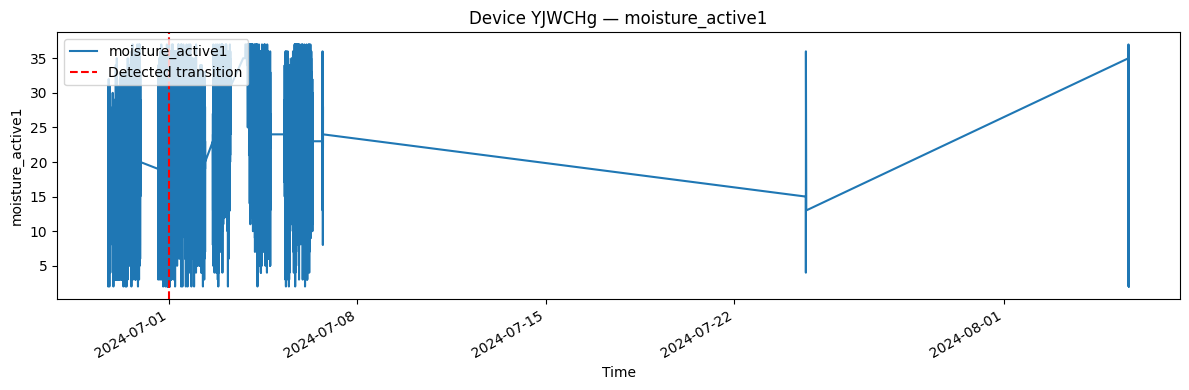

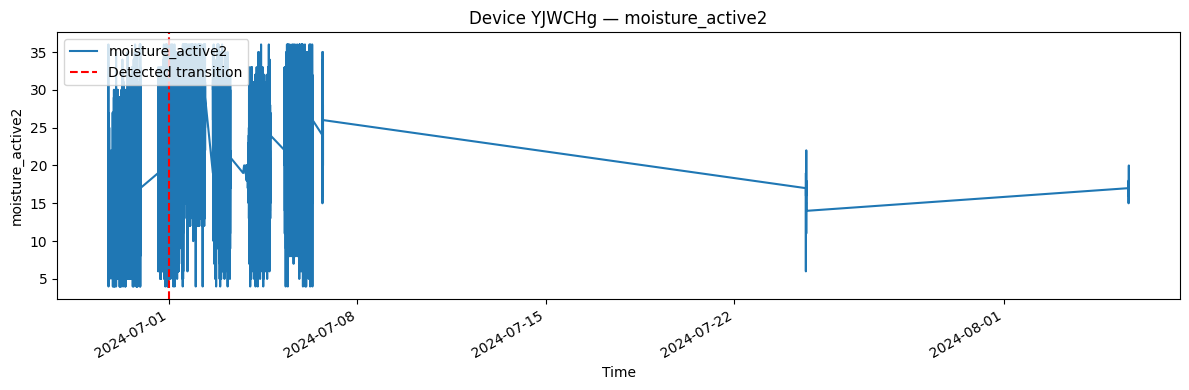

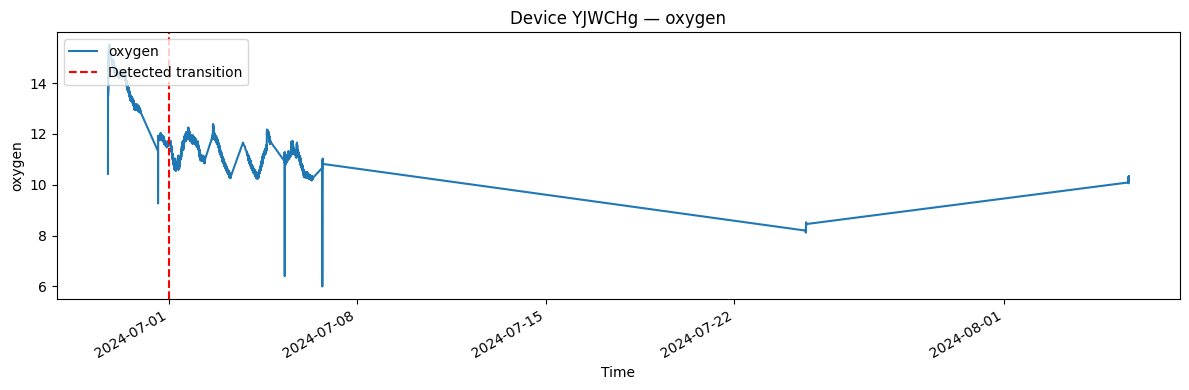

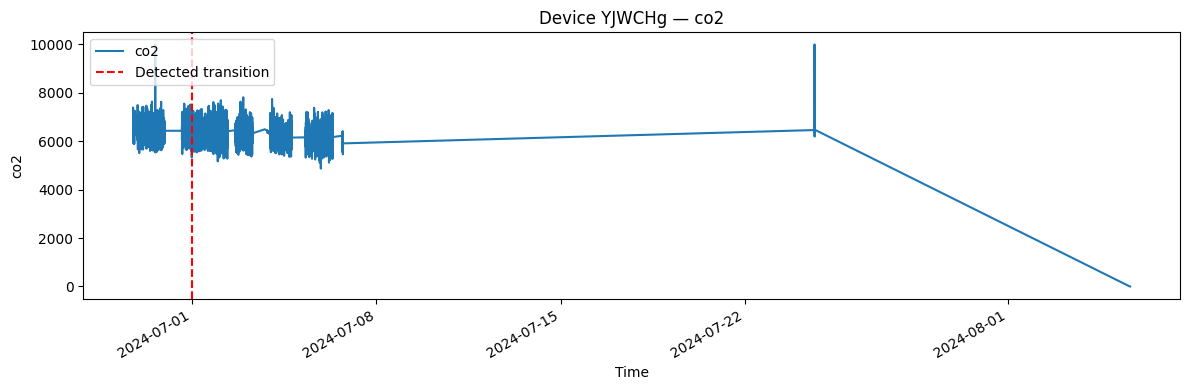

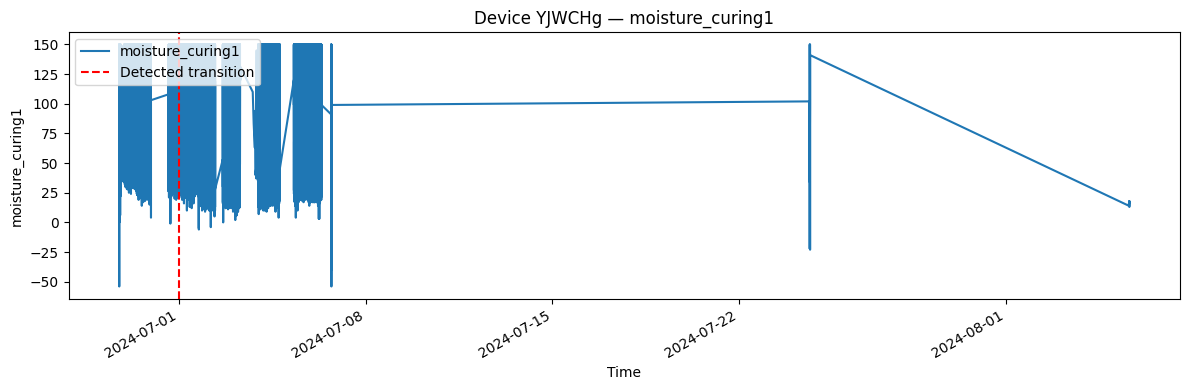

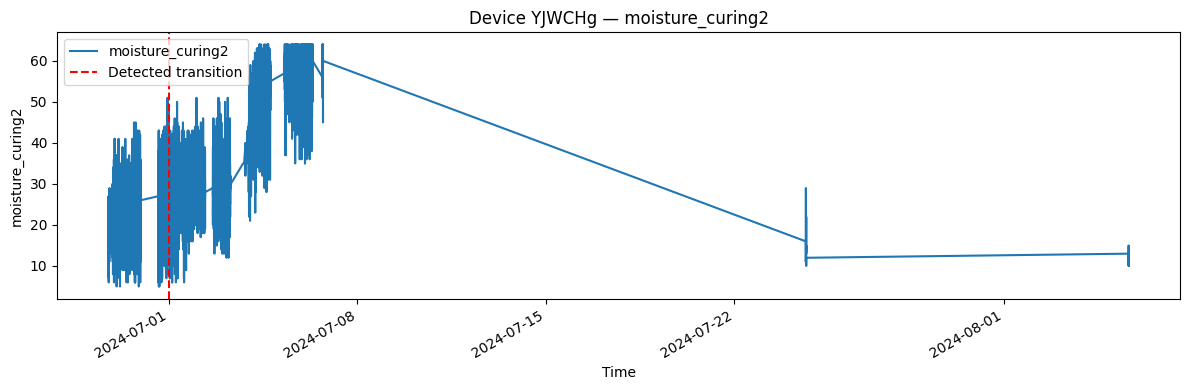

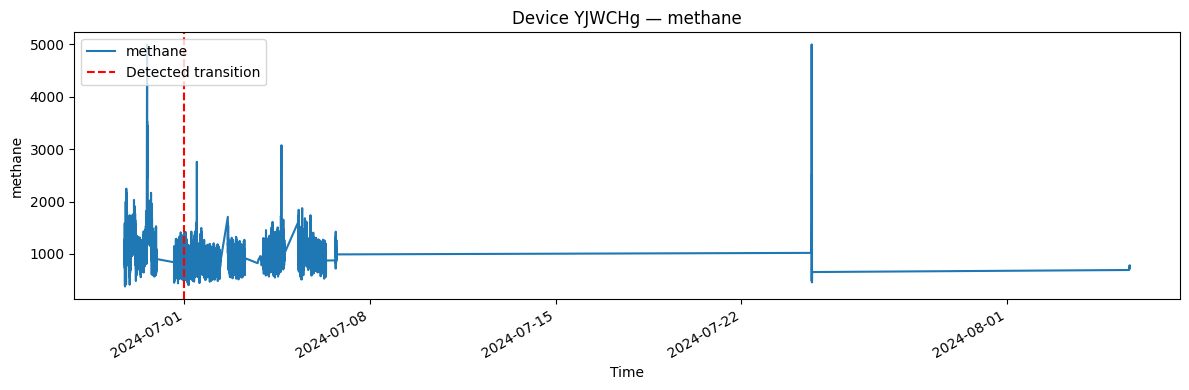

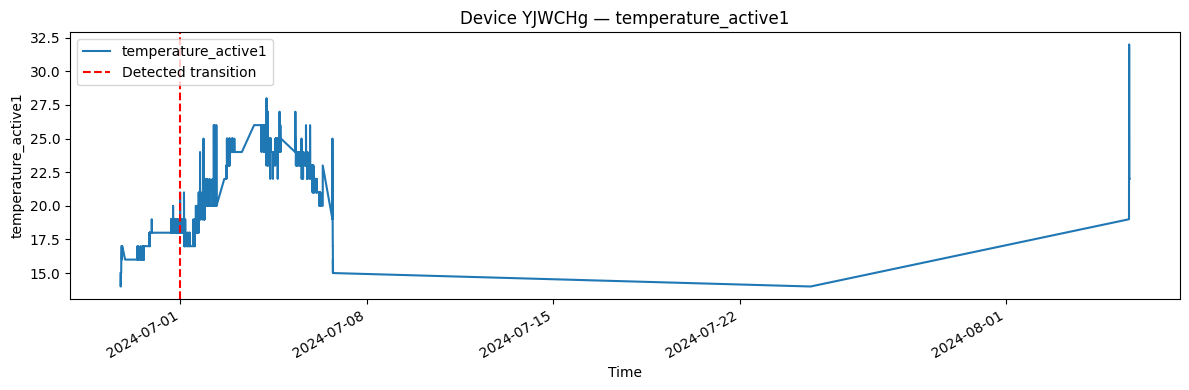

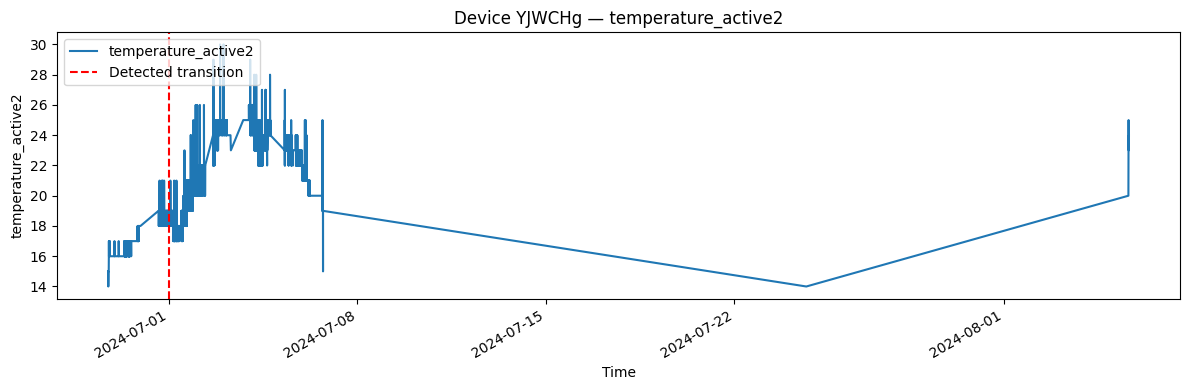

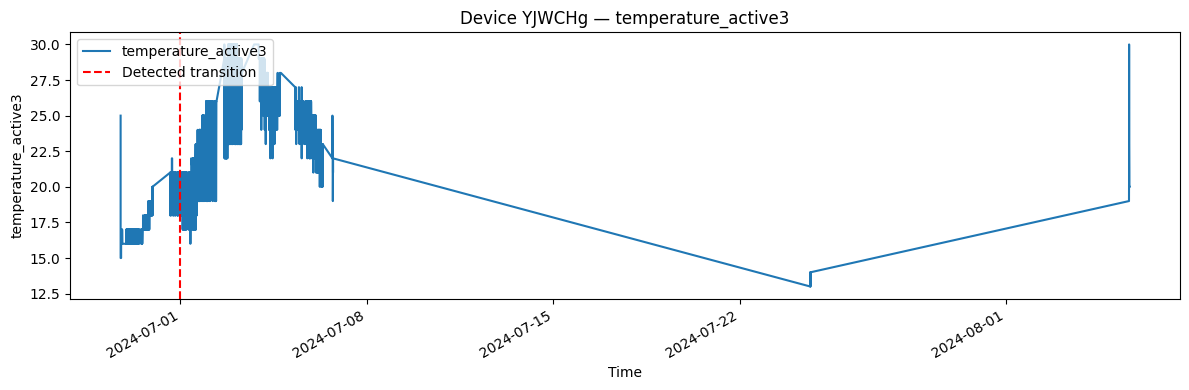

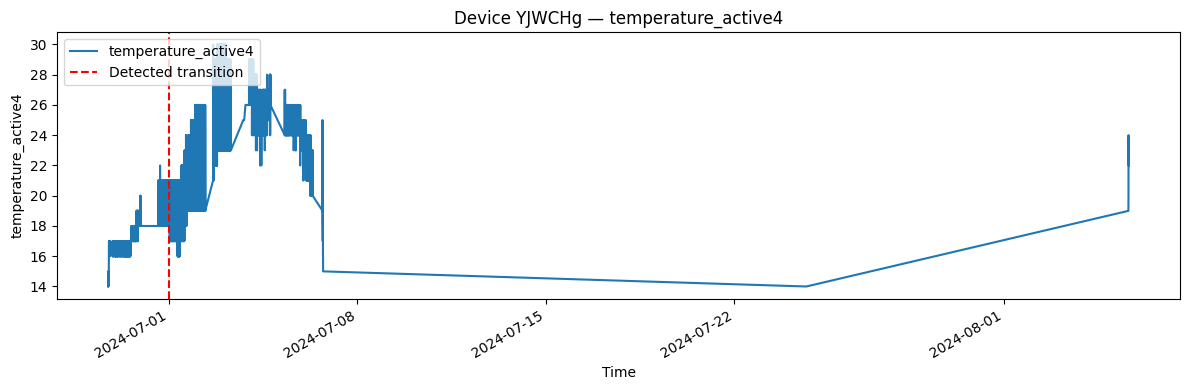

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Make sure all your timestamps are real datetimes
df["time_stamp"] = pd.to_datetime(
    df["time_stamp"], dayfirst=True, format="%d/%m/%Y %H:%M"
)

#  Loop through each device’s detected change-point
for dev, (cp_time_str, cp_idx) in cp_indices_by_device.items():
    # Convert cp_time (if it’s a string) into a Timestamp
    cp_ts = pd.to_datetime(cp_time_str, dayfirst=True, format="%d/%m/%Y %H:%M")

    # Subset and sort the run’s data
    run = (
        df[df["device_id"] == dev]
        .sort_values("time_stamp")
        .reset_index(drop=True)
    )

    # 3) Plot each feature
    for feature in FEATURES:
        fig, ax = plt.subplots(figsize=(12, 4))

        # raw data
        ax.plot(run["time_stamp"], run[feature], label=feature)
        # change point
        ax.axvline(cp_ts, color="red", linestyle="--", label="Detected transition")

        # formatting
        ax.set_title(f"Device {dev} — {feature}")
        ax.set_xlabel("Time")
        ax.set_ylabel(feature)
        ax.legend(loc="upper left")
        plt.gcf().autofmt_xdate()   # rotate date labels
        plt.tight_layout()
        plt.show()

